In [154]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [163]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [164]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']

In [165]:
Features = [feature for feature in df.columns if feature != 'Price' and feature != "Region" and feature != "Actual_Roof_OPOWER" and feature != "Actual_Roof_LASTCHANGED" and feature != "date"]
Features


['Demand',
 'Forecast_Demand_0.5 hour future',
 'Forecast_Demand_1 hour future',
 'Forecast_Demand_1.5 hours future',
 'Forecast_Demand_2 hours future',
 'Forecast_Demand_2.5 hours future',
 'Forecast_Demand_3 hours future',
 'Forecast_Demand_3.5 hours future',
 'Forecast_Demand_4 hours future',
 'Forecast_Demand_4.5 hours future',
 'Forecast_Demand_5 hours future',
 'Forecast_Demand_5.5 hours future',
 'Forecast_Demand_6 hours future',
 'Forecast_Demand_6.5 hours future',
 'Forecast_Demand_7 hours future',
 'Forecast_Demand_7.5 hours future',
 'Forecast_Demand_8 hours future',
 'Forecast_Demand_8.5 hours future',
 'Forecast_Demand_9 hours future',
 'Forecast_Demand_9.5 hours future',
 'Forecast_Roof_0.5 hour future',
 'Forecast_Roof_1 hour future',
 'Forecast_Roof_1.5 hours future',
 'Forecast_Roof_2 hours future',
 'Forecast_Roof_2.5 hours future',
 'Forecast_Roof_3 hours future',
 'Forecast_Roof_3.5 hours future',
 'Forecast_Roof_4 hours future',
 'Forecast_Roof_4.5 hours future',
 

In [166]:
for feature in Features:
    if feature != 'Price':  
        df[f'{feature}_shift_1'] = df[feature].shift(1)
        df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_4976\2512749088.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_1'] = df[feature].shift(1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_4976\2512749088.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_6'] = df[feature].shift(6)
C:\Users\Owner\AppData\Local\Temp\ipykernel_4976\2512749088.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [167]:
df.columns


Index(['date', 'Demand', 'Price', 'Region', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future',
       ...
       'minute_shift_1', 'minute_shift_6', 'EMA_4h_shift_1', 'EMA_4h_shift_6',
       'EMA_1d_shift_1', 'EMA_1d_shift_6',
       'Forecast_difference_0.5 hour future_shift_1',
       'Forecast_difference_0.5 hour future_shift_6',
       'Forecast_ratio_0.5 hour future_shift_1',
       'Forecast_ratio_0.5 hour future_shift_6'],
      dtype='object', length=155)

In [168]:
df.set_index('date', inplace=True)
X = df[Features + [f'{feature}_shift_1' for feature in Features] +
                  [f'{feature}_shift_6' for feature in Features]]
y = df['Price']

split_date = pd.to_datetime("2024-06-01 00:00:00")
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [169]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 180,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "lambda":0.9,
    'random_state': 42
}


In [170]:
import xgboost as xgb
model = xgb.XGBRegressor(**params)

# 5. 訓練模型
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='mae',
          early_stopping_rounds=30,
          verbose=True)

[0]	validation_0-mae:65.74951	validation_1-mae:84.00524


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:65.19451	validation_1-mae:83.43885
[2]	validation_0-mae:64.64262	validation_1-mae:82.85196
[3]	validation_0-mae:64.10125	validation_1-mae:82.28903
[4]	validation_0-mae:63.57579	validation_1-mae:81.70530
[5]	validation_0-mae:63.04606	validation_1-mae:81.17495
[6]	validation_0-mae:62.52003	validation_1-mae:80.61574
[7]	validation_0-mae:62.00198	validation_1-mae:80.09050
[8]	validation_0-mae:61.48624	validation_1-mae:79.58432
[9]	validation_0-mae:60.97671	validation_1-mae:79.07368
[10]	validation_0-mae:60.48953	validation_1-mae:78.58062
[11]	validation_0-mae:59.99954	validation_1-mae:78.07661
[12]	validation_0-mae:59.51469	validation_1-mae:77.55941
[13]	validation_0-mae:59.03799	validation_1-mae:77.08149
[14]	validation_0-mae:58.55692	validation_1-mae:76.57468
[15]	validation_0-mae:58.08549	validation_1-mae:76.08648
[16]	validation_0-mae:57.61286	validation_1-mae:75.60341
[17]	validation_0-mae:57.15131	validation_1-mae:75.12466
[18]	validation_0-mae:56.70697	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.9, learning_rate=0.01,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, ...)

In [171]:
y_pred = model.predict(X_test)

In [172]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 39856.80045645671
Mean Absolute Error: 40.59311429896171
Root Mean Squared Error: 199.6416801583695


In [173]:
feature_importance = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


Top 10 Most Important Features:
                                         feature  importance
49                Forecast_ratio_0.5 hour future    0.138600
48           Forecast_difference_0.5 hour future    0.120780
98   Forecast_difference_0.5 hour future_shift_1    0.119493
99        Forecast_ratio_0.5 hour future_shift_1    0.104184
97                                EMA_1d_shift_1    0.025574
120        Forecast_Roof_0.5 hour future_shift_6    0.023788
47                                        EMA_1d    0.022520
20                 Forecast_Roof_0.5 hour future    0.022048
70         Forecast_Roof_0.5 hour future_shift_1    0.021797
64        Forecast_Demand_7 hours future_shift_1    0.021209


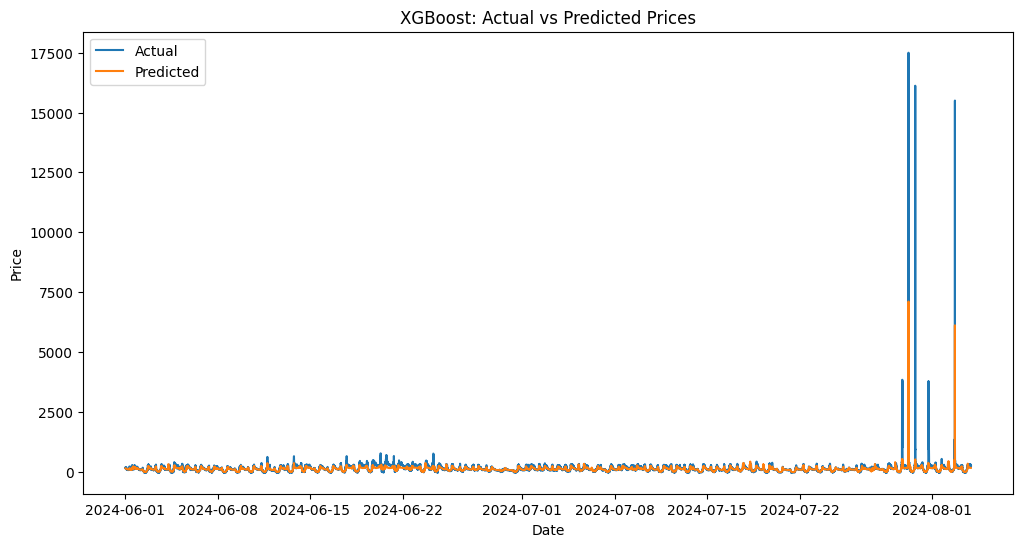

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

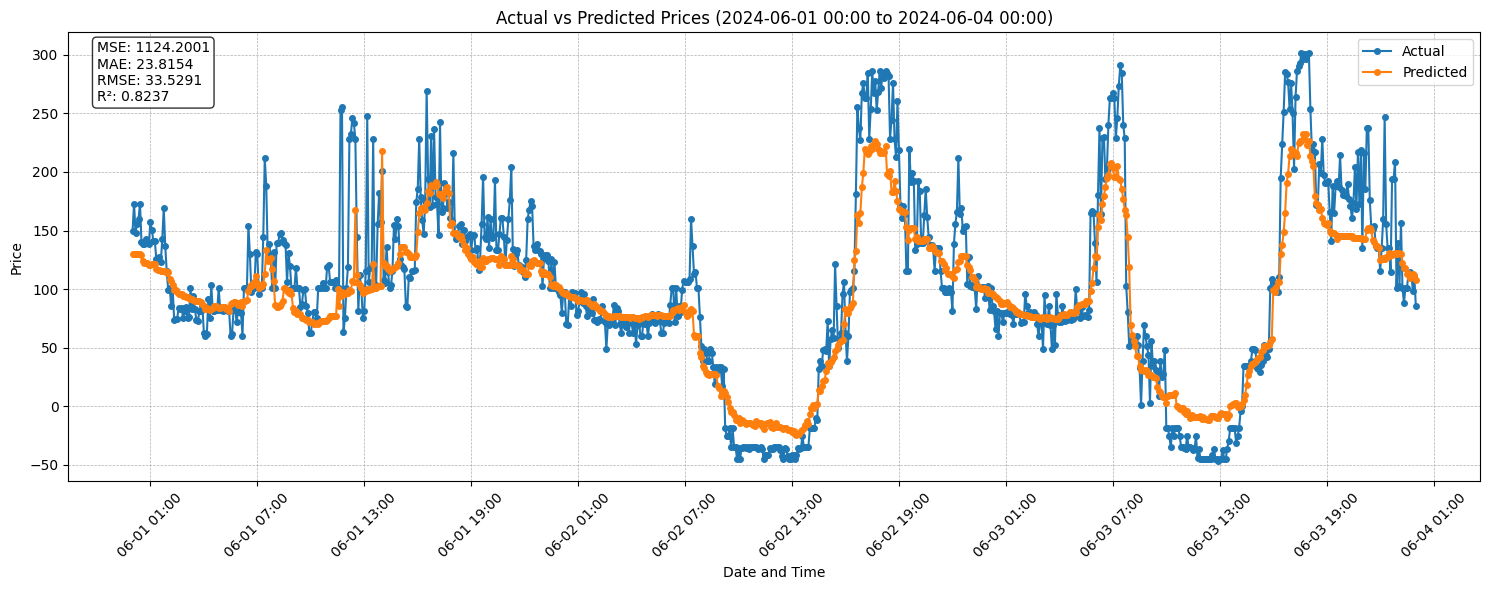

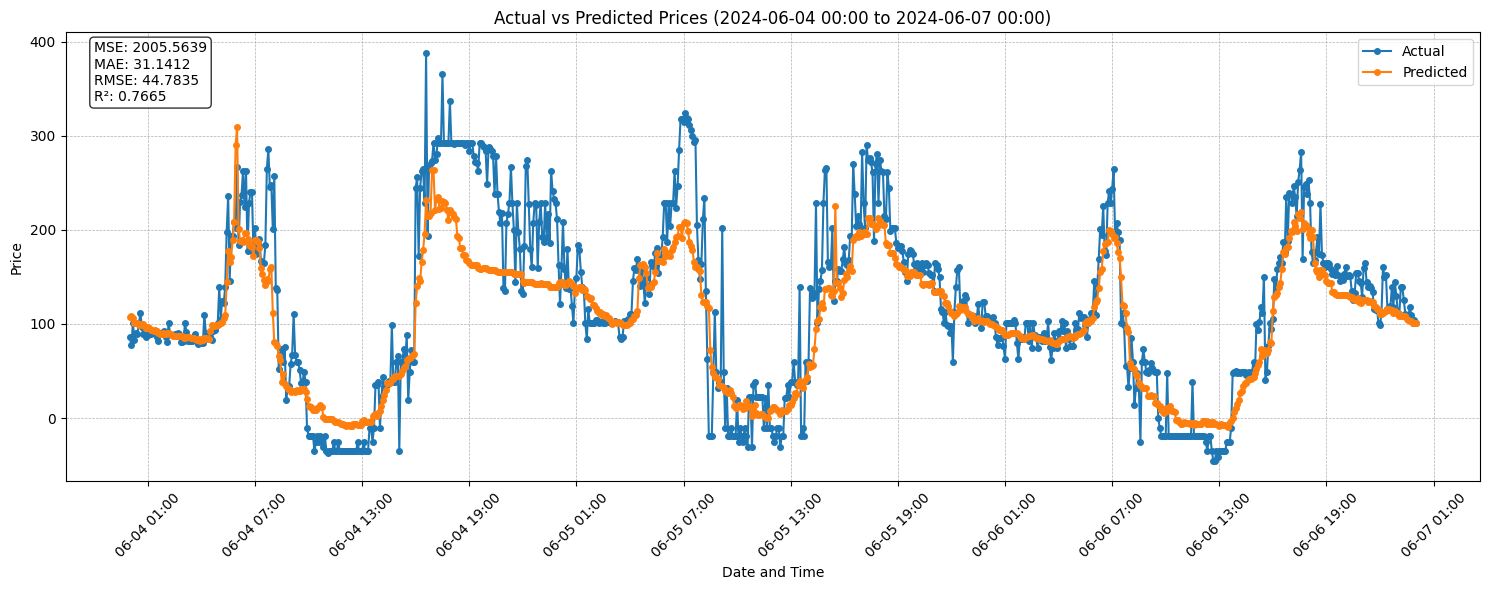

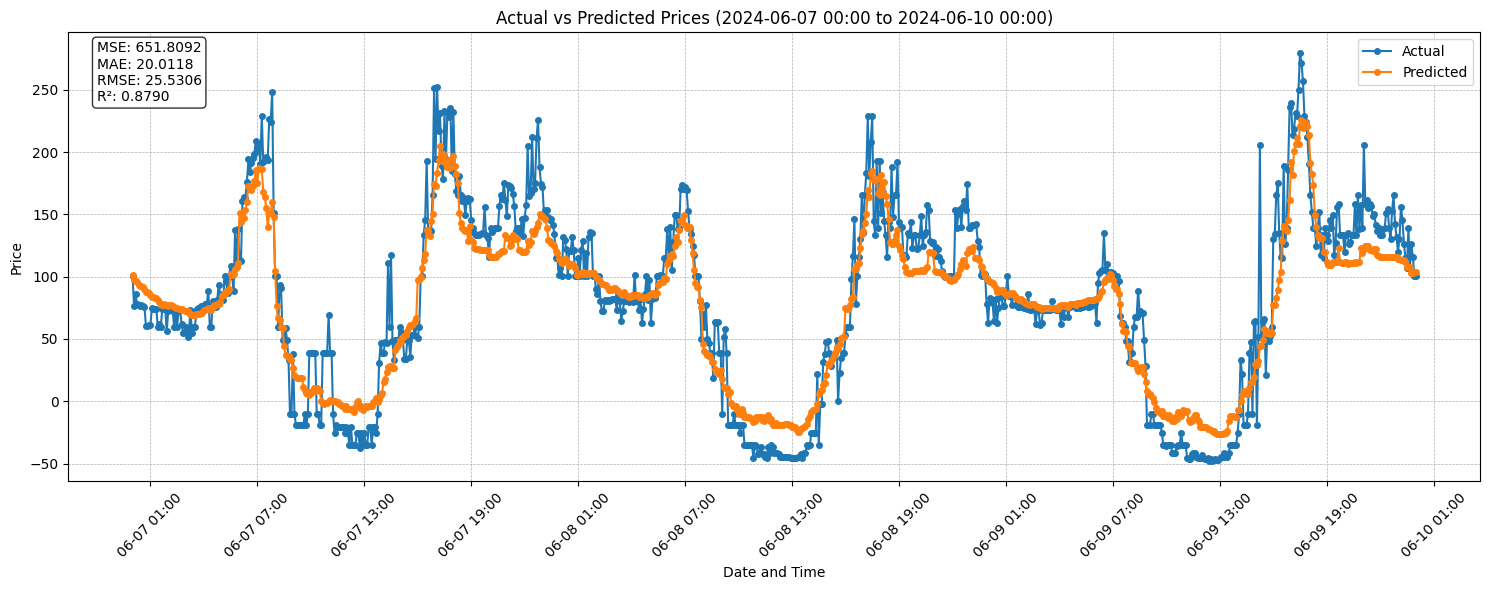

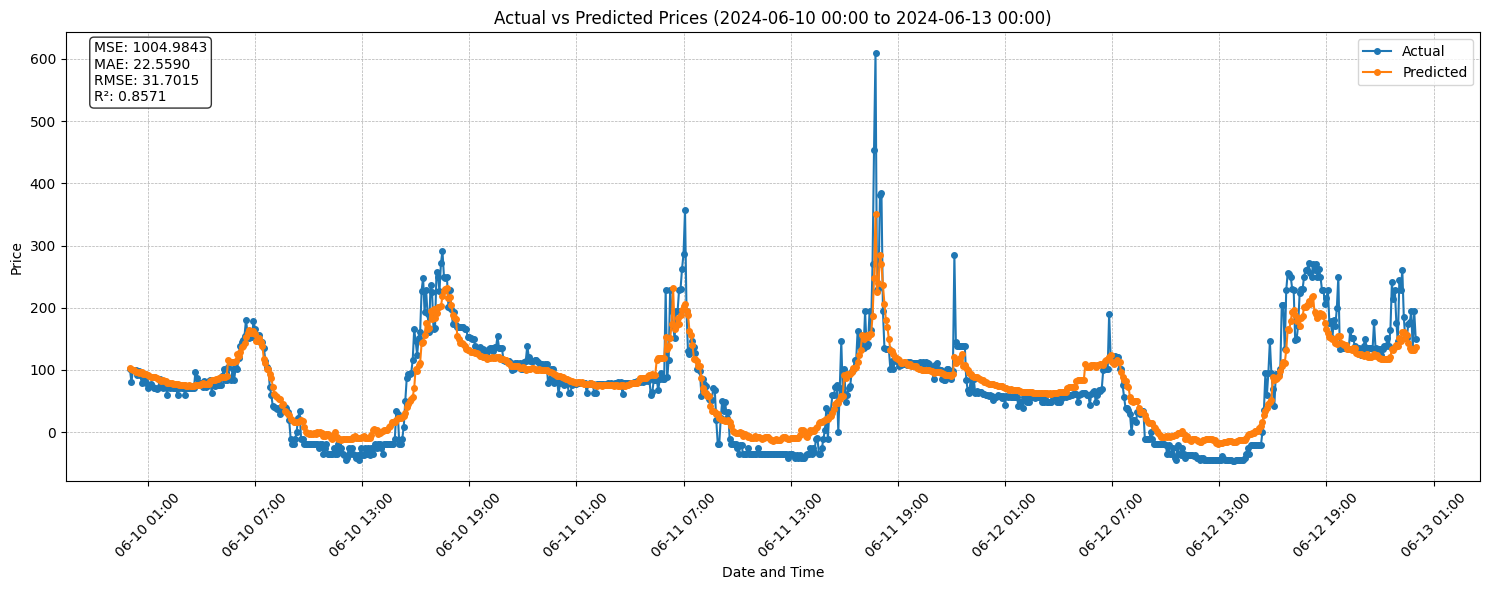

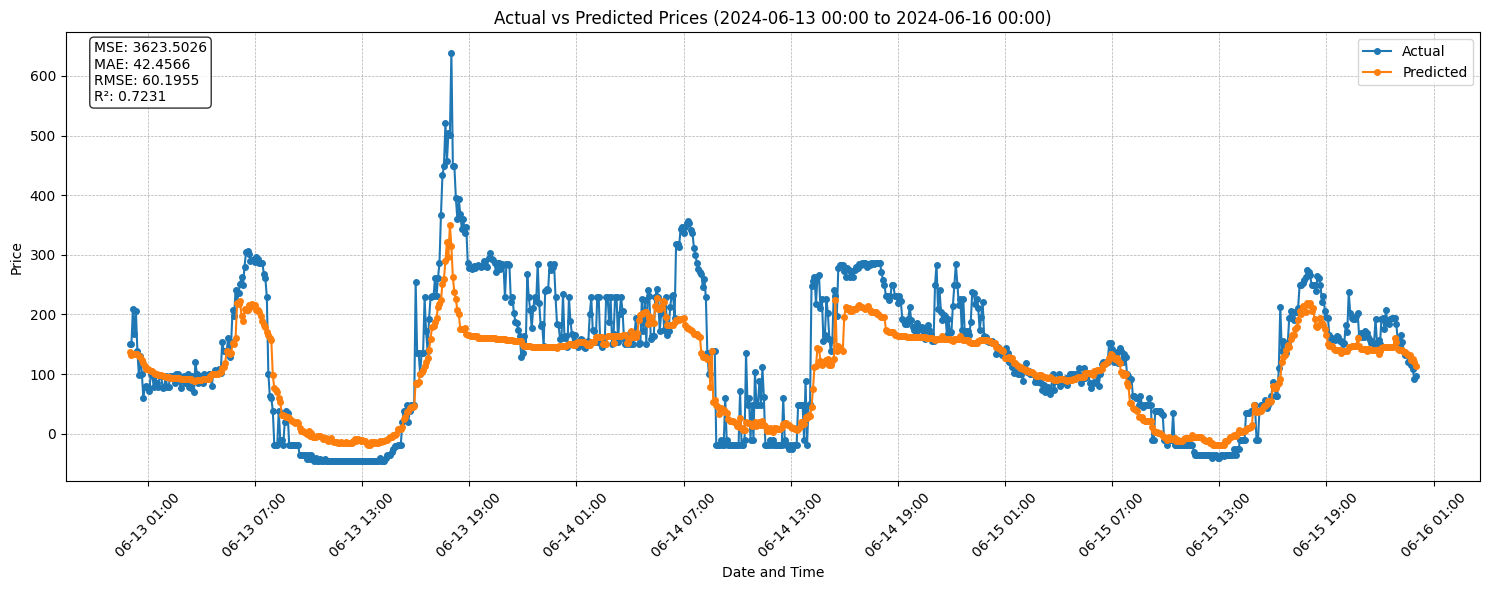

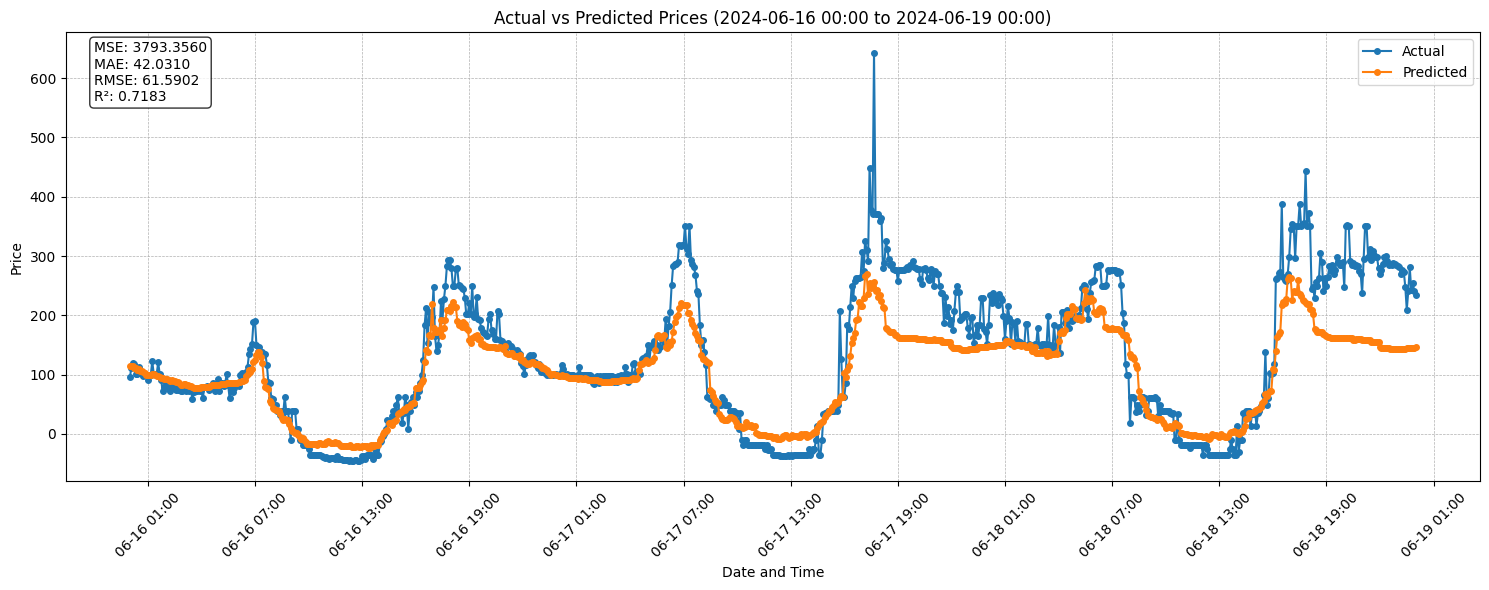

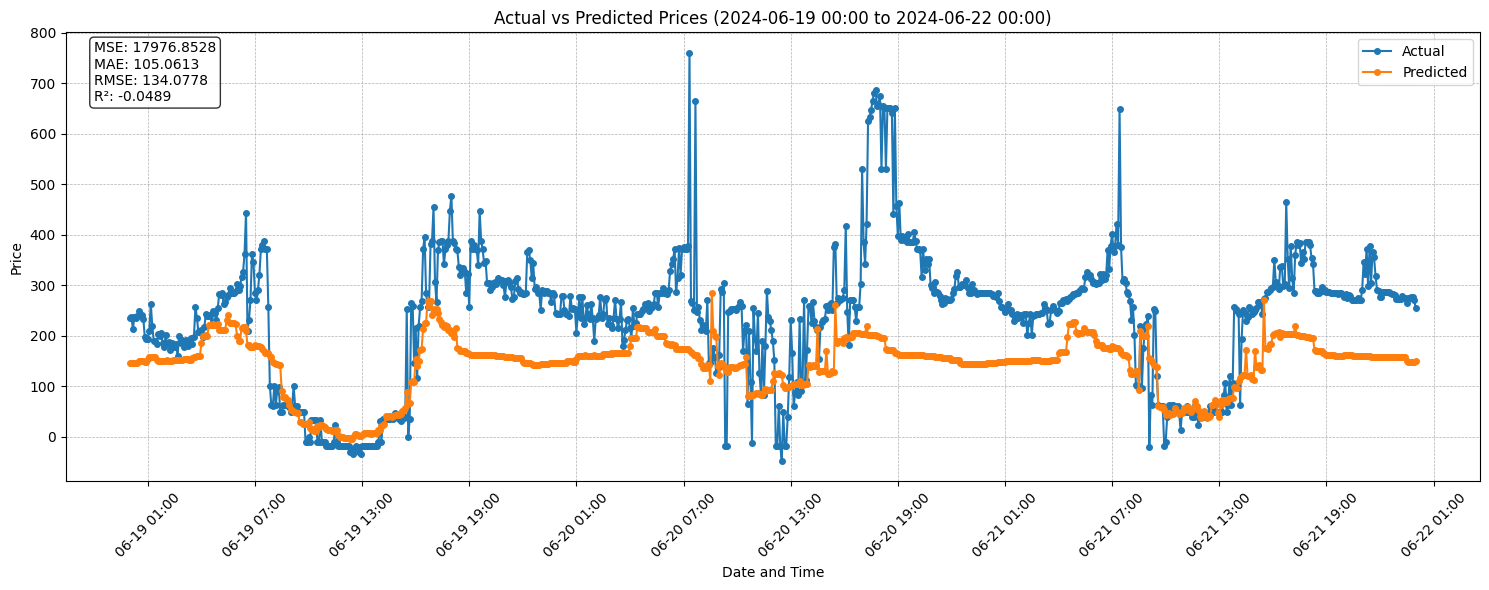

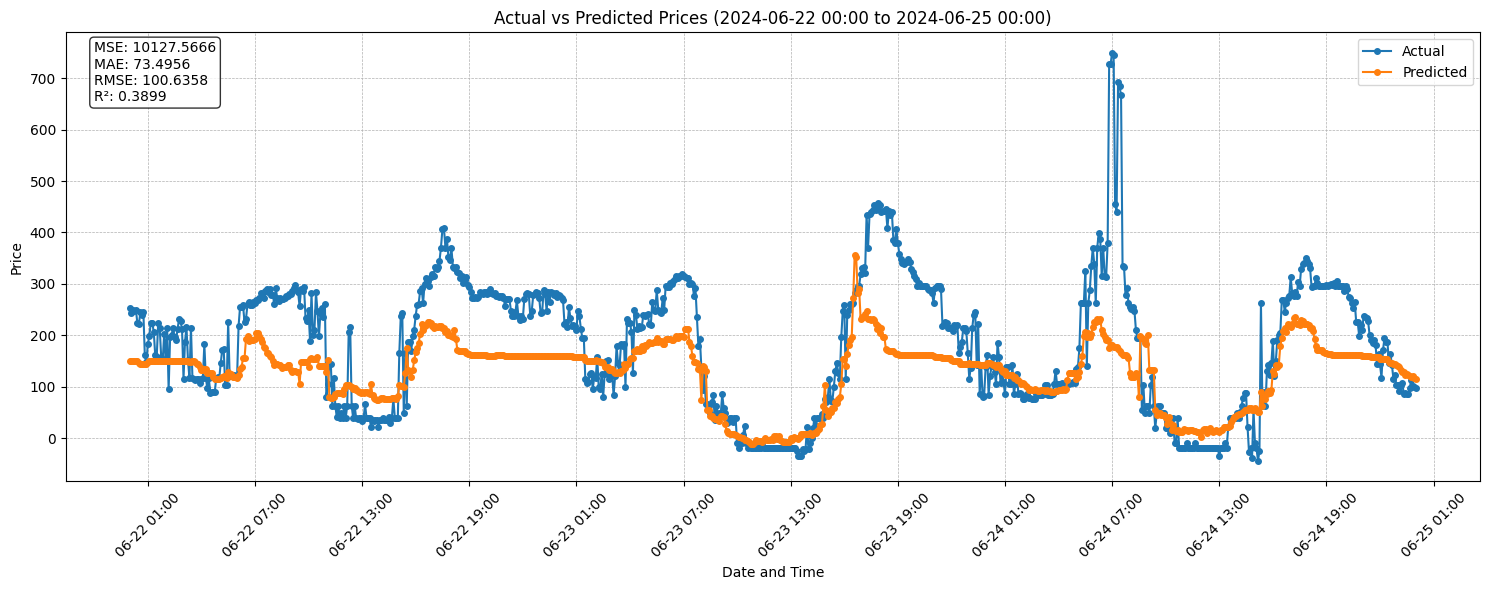

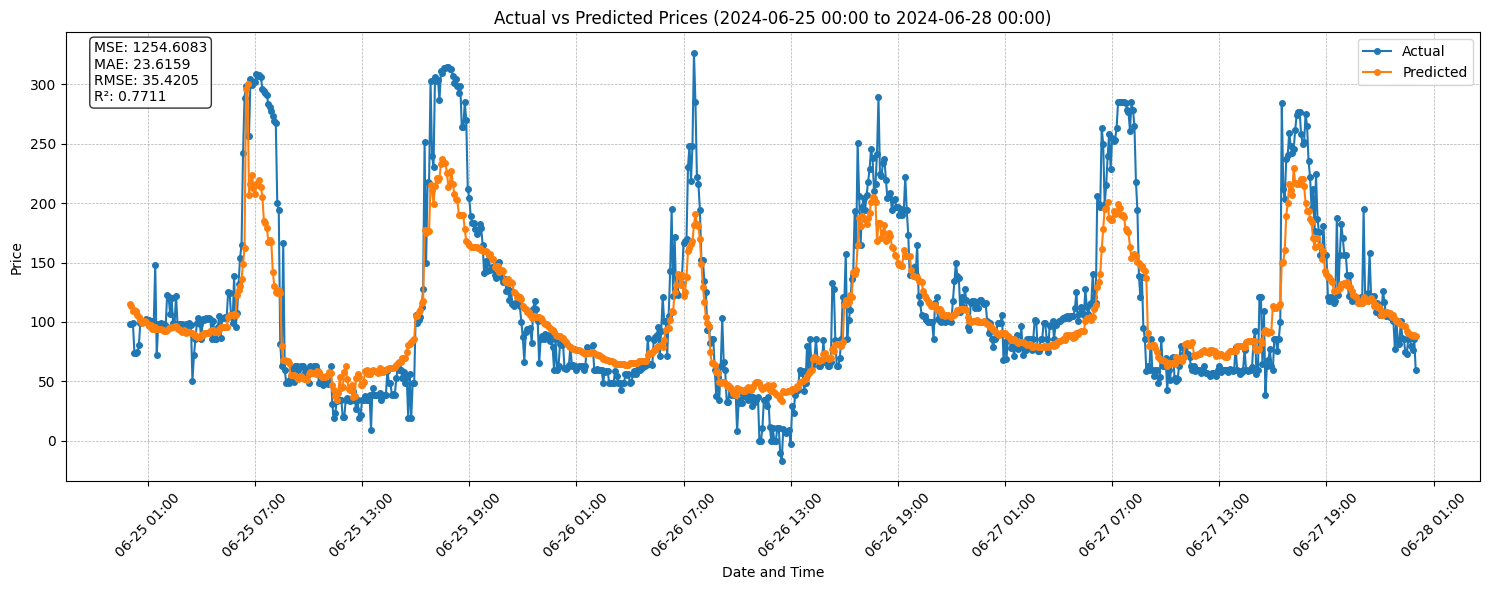

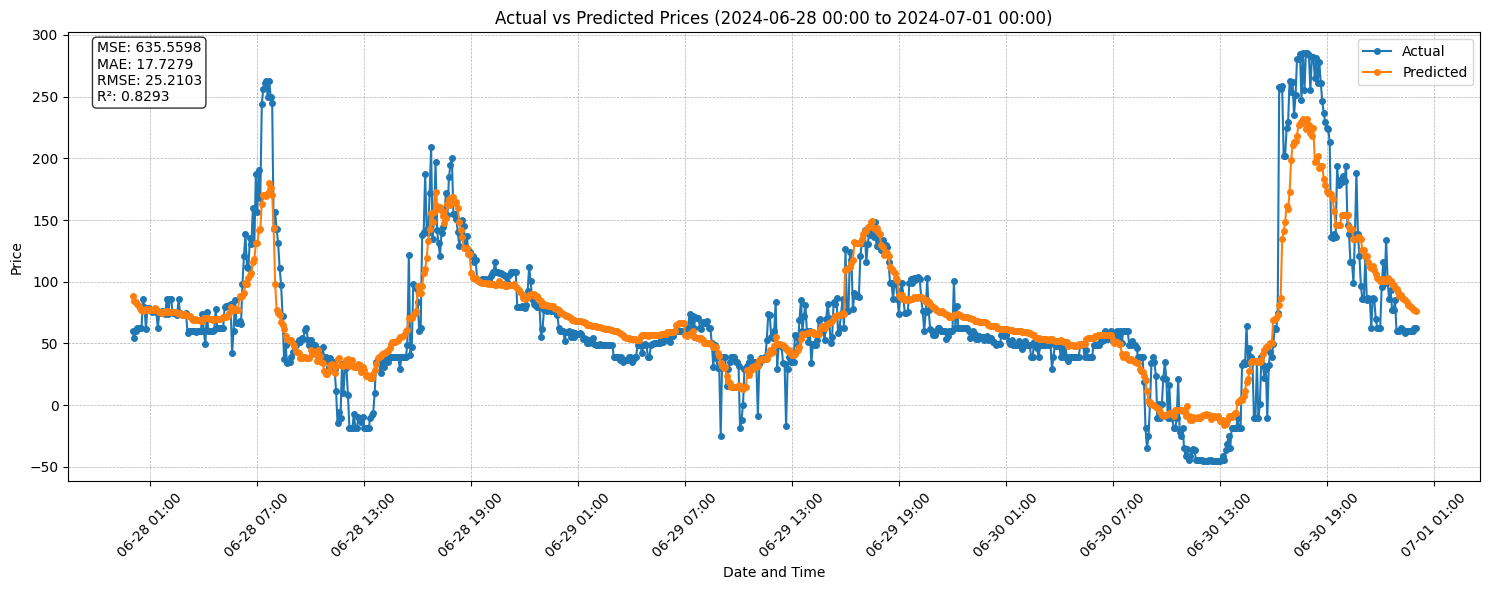

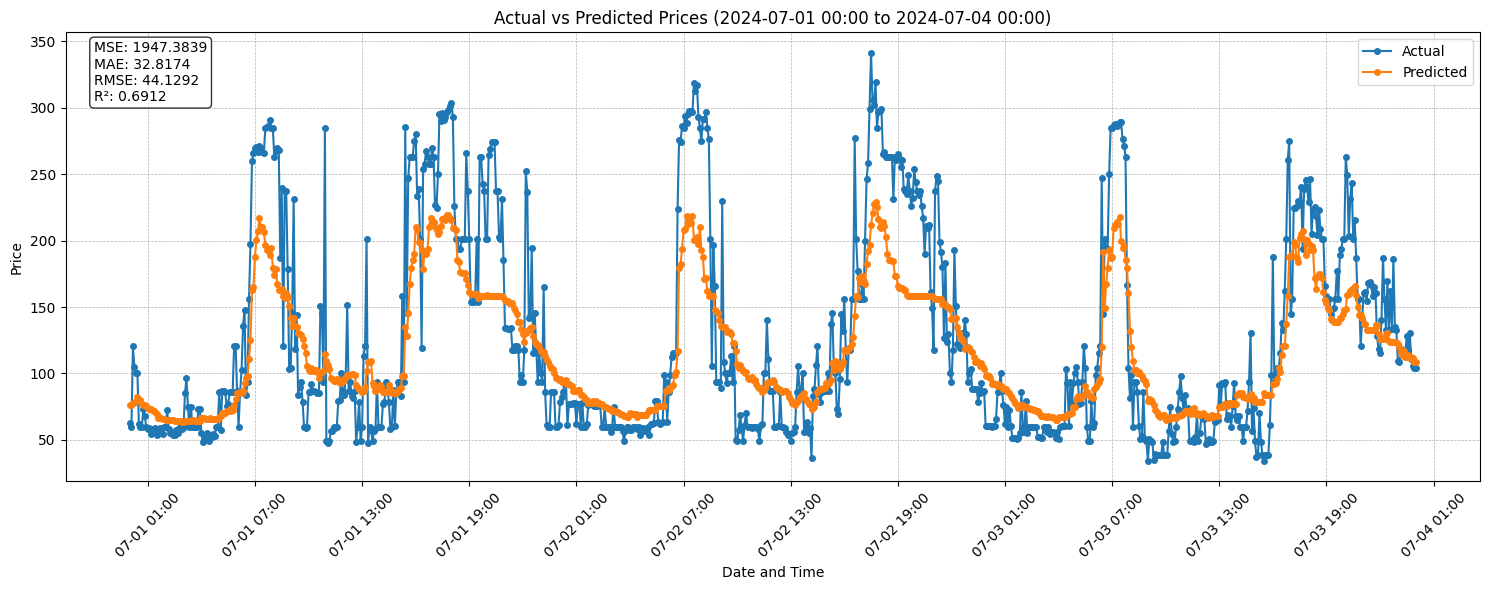

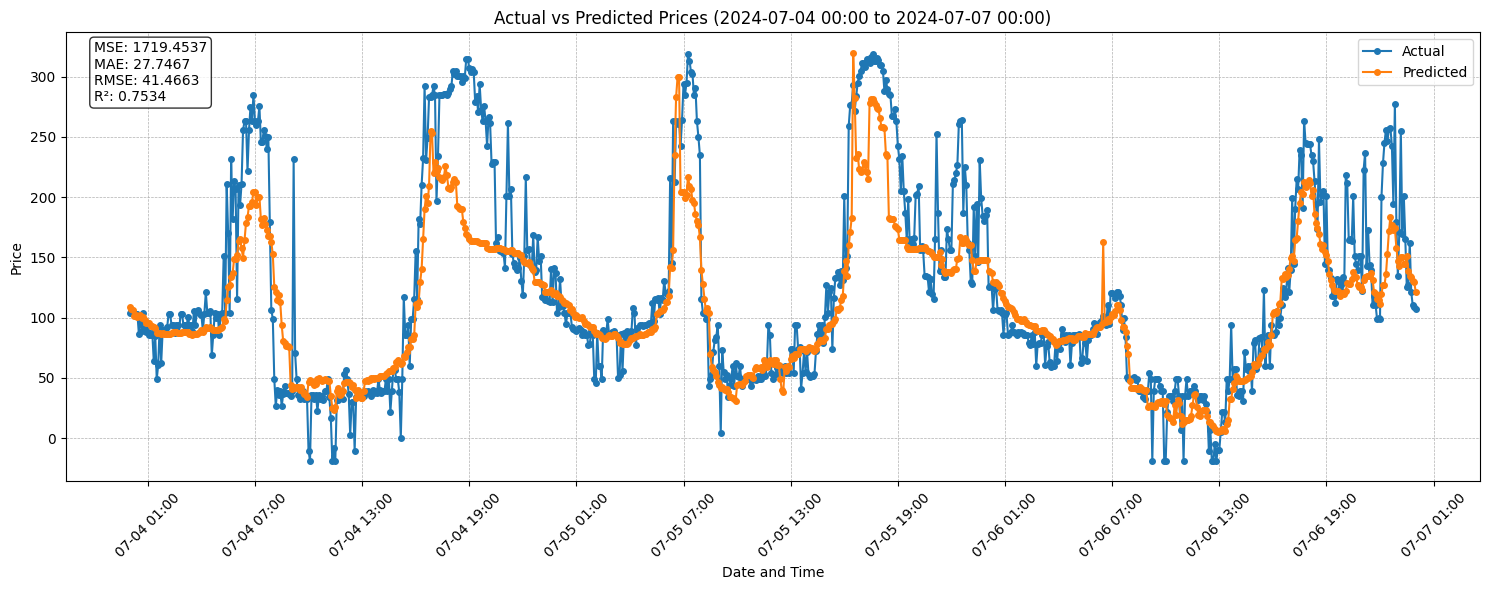

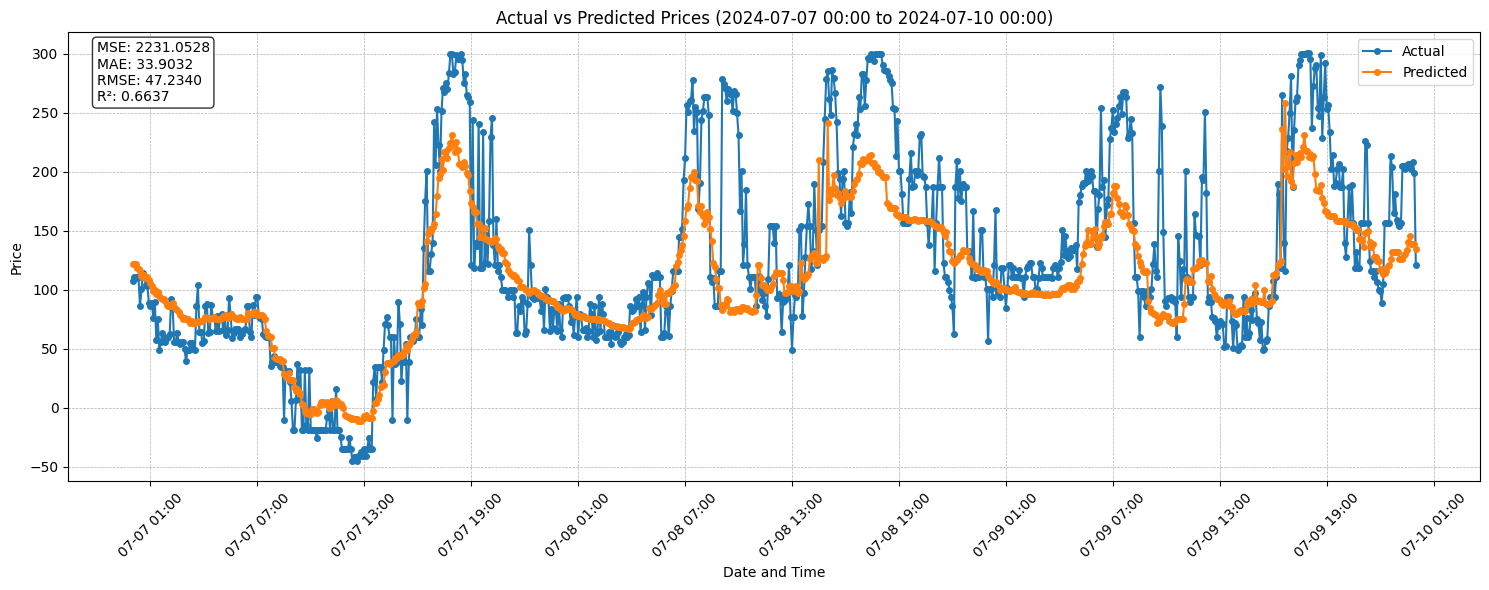

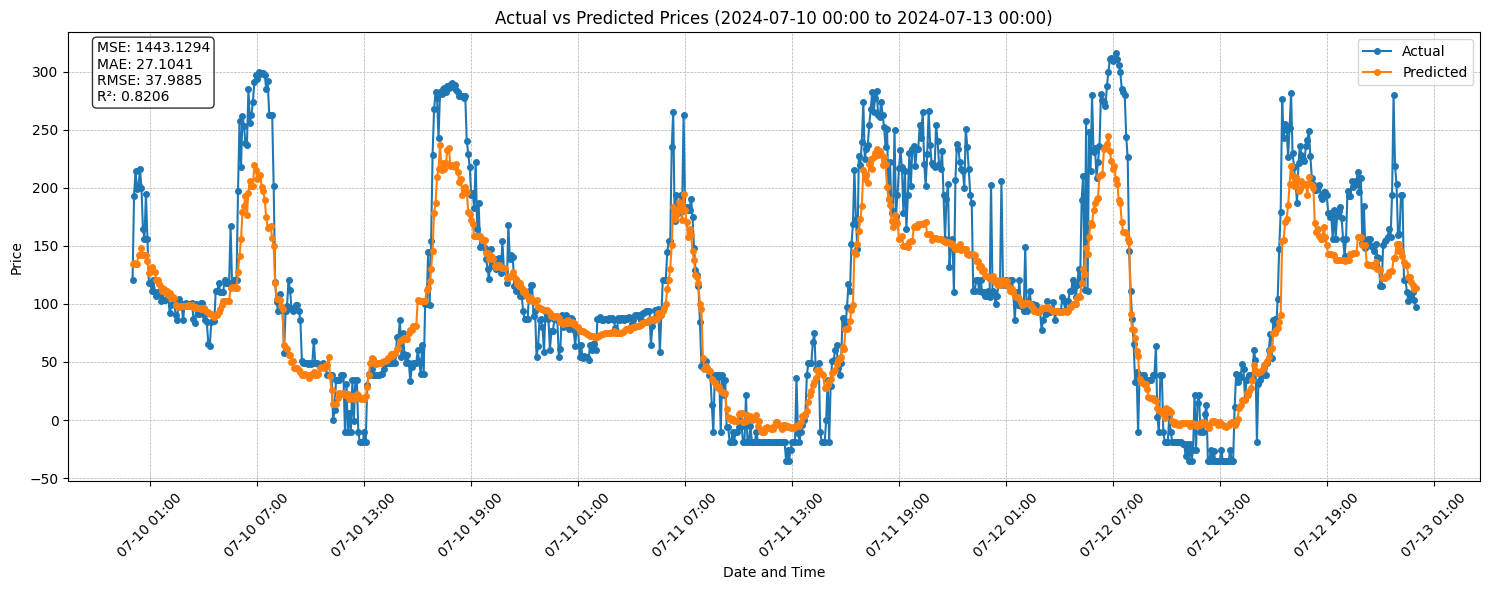

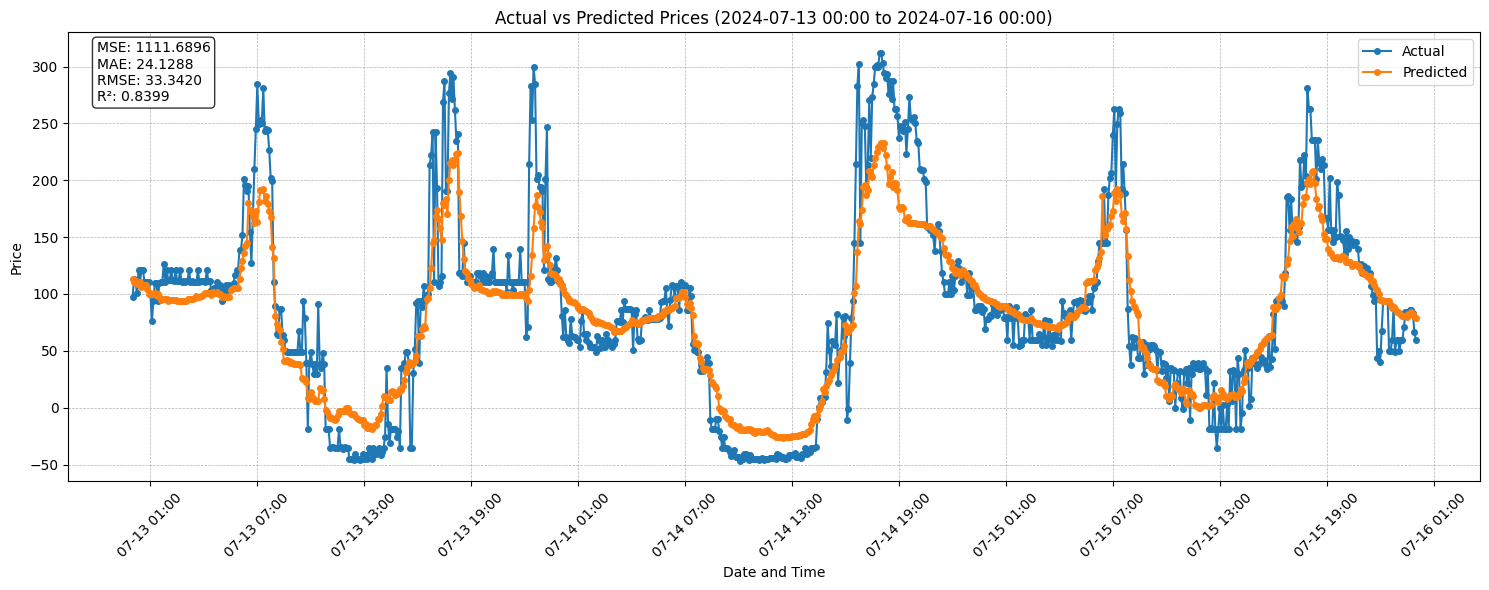

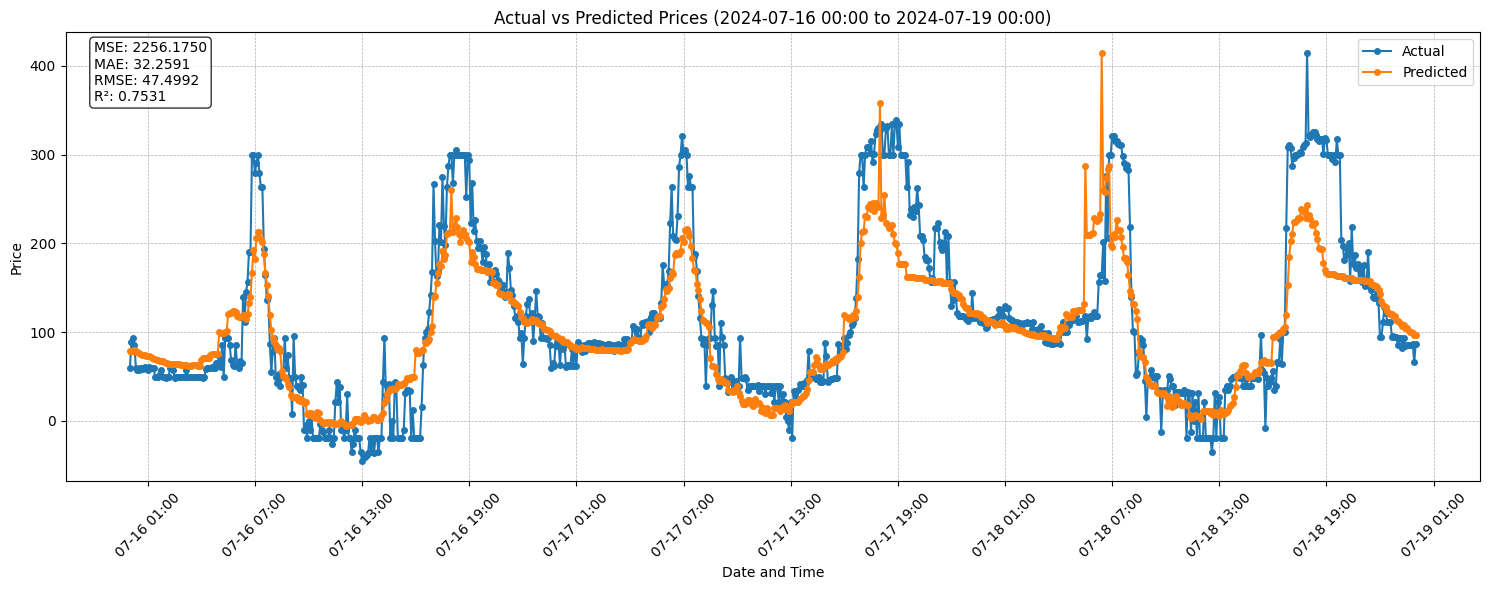

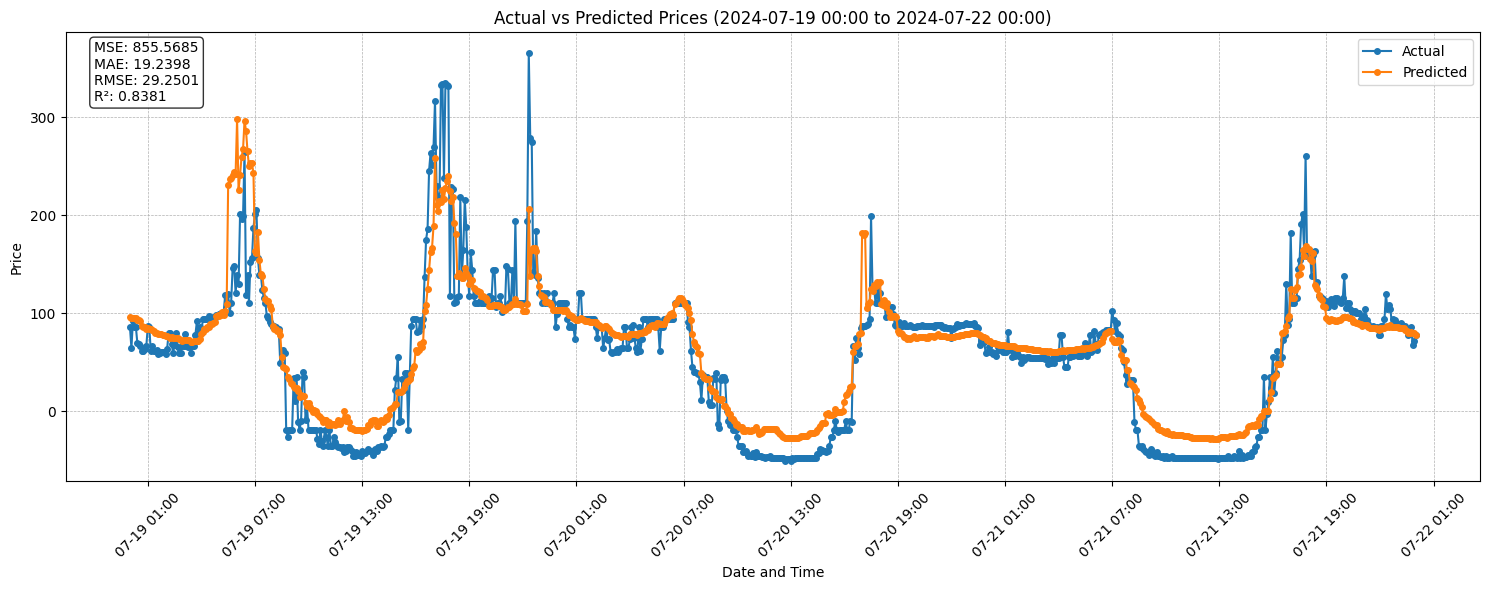

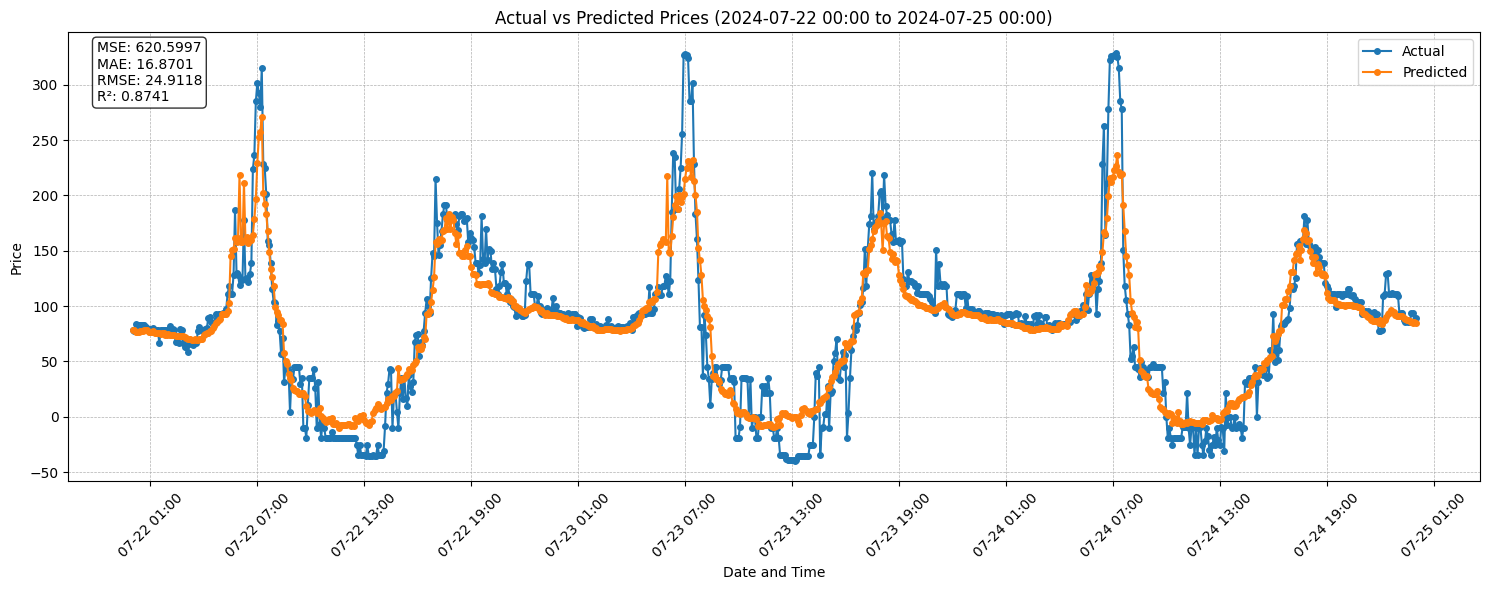

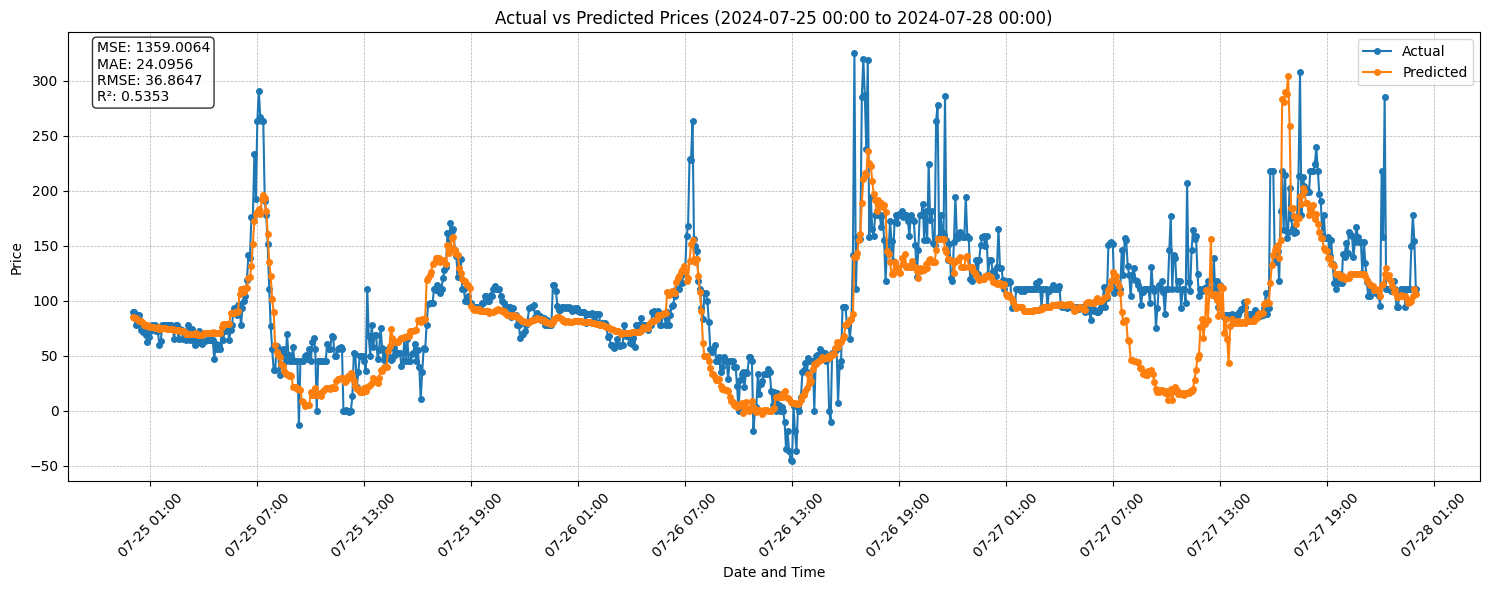

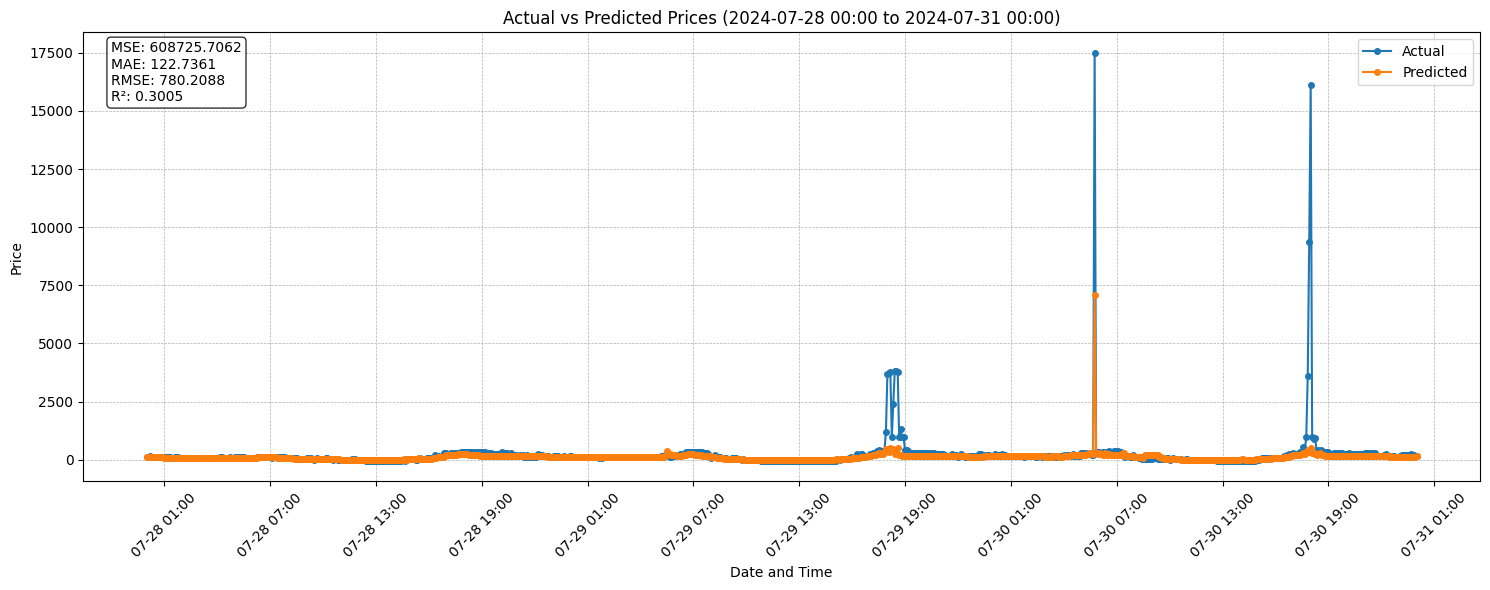

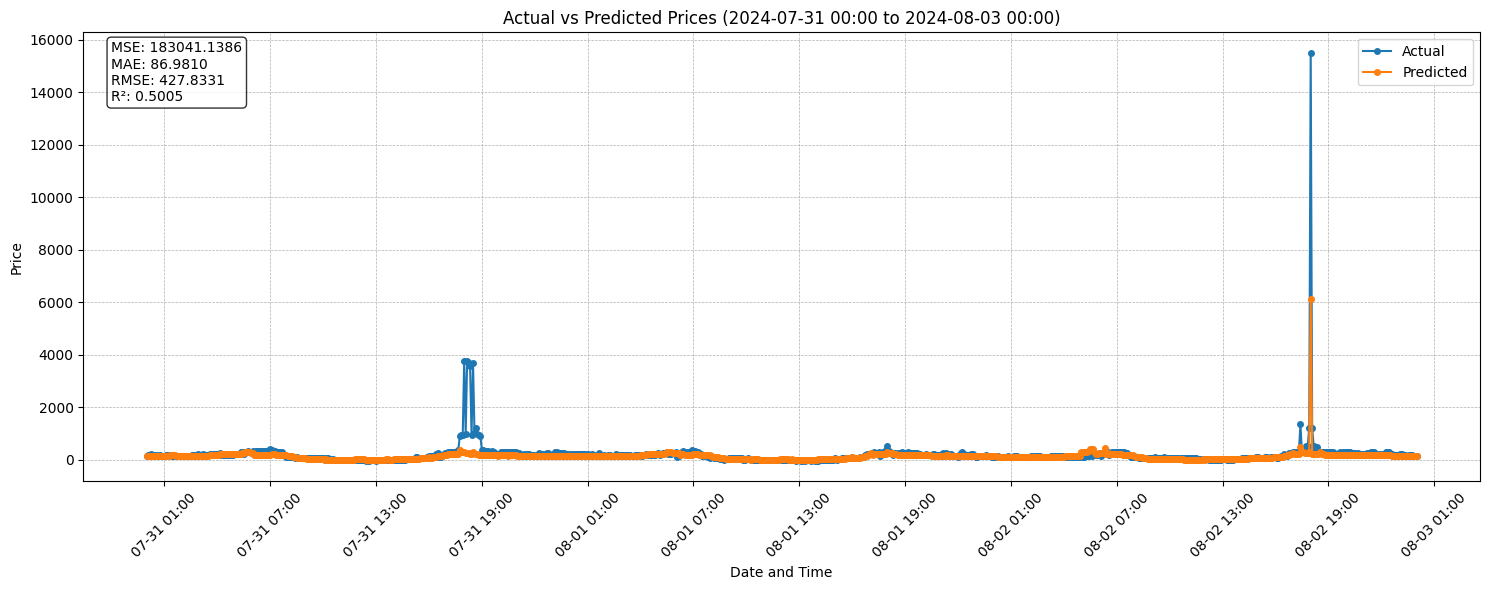

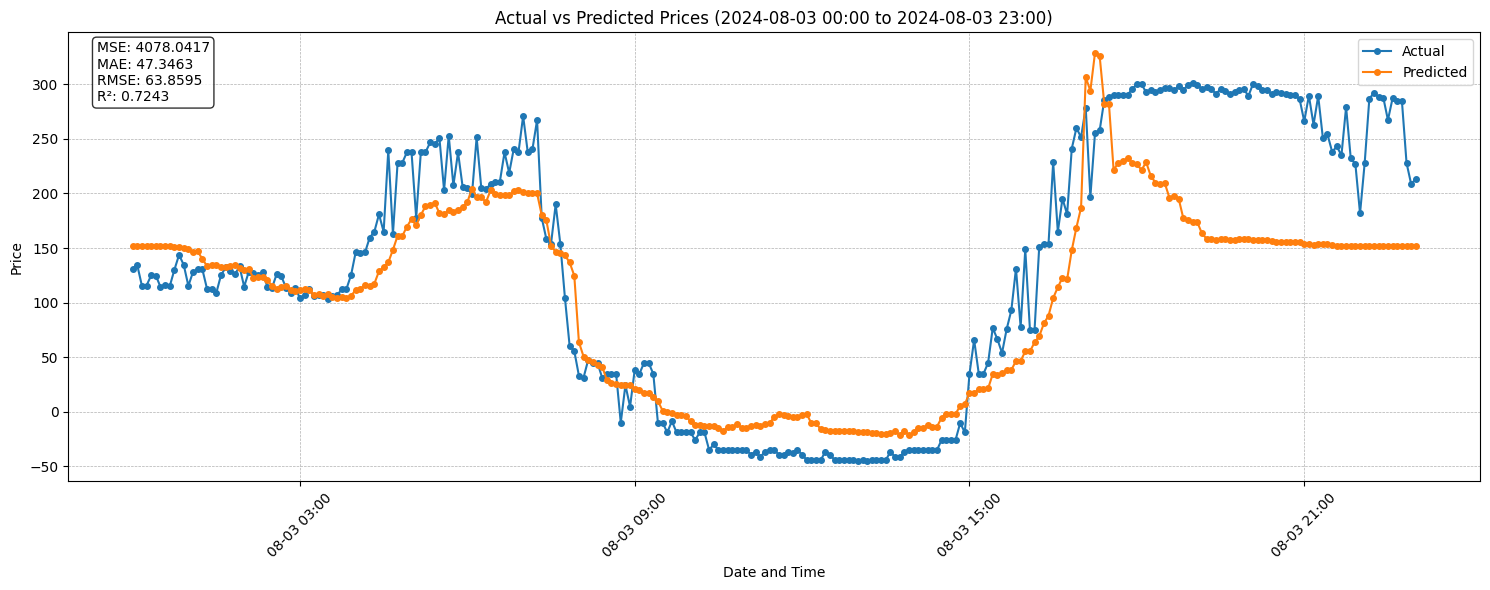

Overall Performance Metrics:
Mean Squared Error: 39856.8005
Mean Absolute Error: 40.5931
Root Mean Squared Error: 199.6417
R-squared Score: 0.4114


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假設 y_test 和 y_pred 已經準備好，且 y_test 的索引是日期時間類型

# 將實際值和預測值合併到一個 DataFrame 中
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='Predicted', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices ({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    
    # 設置 x 軸刻度
    ax.xaxis.set_major_locator(HourLocator(interval=6))  # 每6小時一個刻度
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))  # 日期和時間格式
    # ax.xaxis.set_major_locator(DayLocator())  # 主刻度為每天
    # ax.xaxis.set_minor_locator(HourLocator(interval=6))  # 次刻度為每6小時
    # ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  # 日期格式
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 添加性能指標到圖表
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

# 獲取數據的起始和結束日期
start_date = results_df.index.min()
end_date = results_df.index.max()

# 按三天遍歷數據
current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)

# 打印整體性能指標
mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(results_df['Actual'], results_df['Predicted'])

print(f"Overall Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Hourly MAE (sorted from highest to lowest):
hour
18    167.468255
17     86.197670
7      65.198436
19     59.321706
6      48.735732
20     48.679692
16     43.540569
22     41.478223
5      39.905994
21     37.054120
8      34.091980
9      32.942918
23     30.229420
15     28.675427
12     26.867200
14     25.708307
13     25.550857
10     25.491140
11     25.138154
0      22.686333
1      15.723449
3      14.639127
4      14.389172
2      14.372425
Name: abs_error, dtype: float64


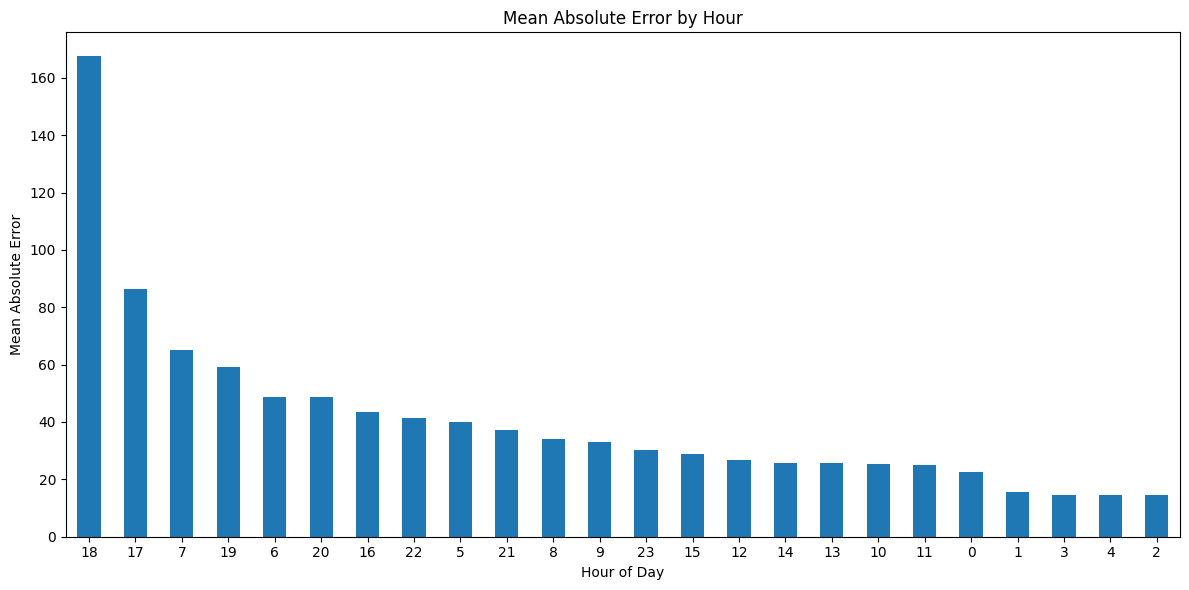

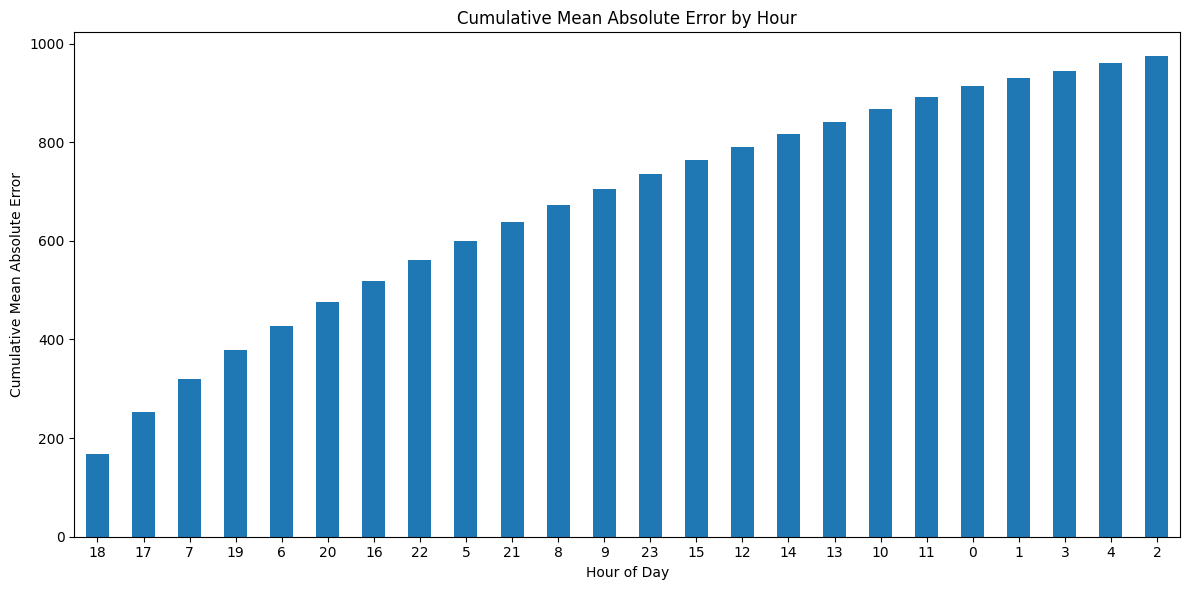


Percentage contribution to total MAE by hour:
hour
18    17.192343
17     8.849079
7      6.693291
19     6.089985
6      5.003225
20     4.997472
16     4.469888
22     4.258167
5      4.096762
21     3.803987
8      3.499893
9      3.381930
23     3.103362
15     2.943828
12     2.758195
14     2.639223
13     2.623059
10     2.616928
11     2.580691
0      2.328986
1      1.614174
3      1.502857
4      1.477197
2      1.475478
Name: abs_error, dtype: float64


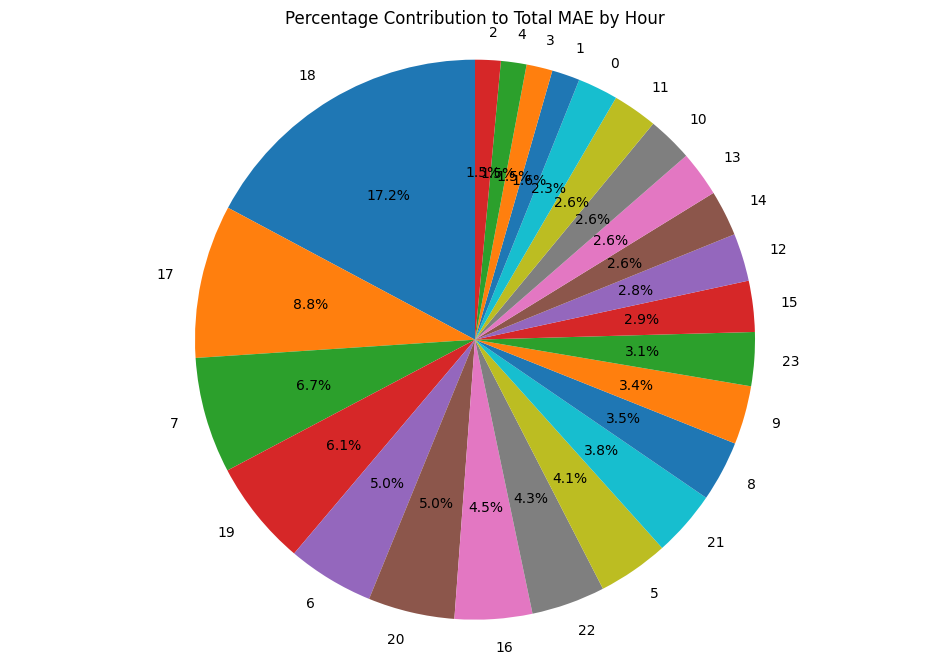


Top 5 hours with highest MAE:
hour
18    167.468255
17     86.197670
7      65.198436
19     59.321706
6      48.735732
Name: abs_error, dtype: float64


<Figure size 1500x600 with 0 Axes>

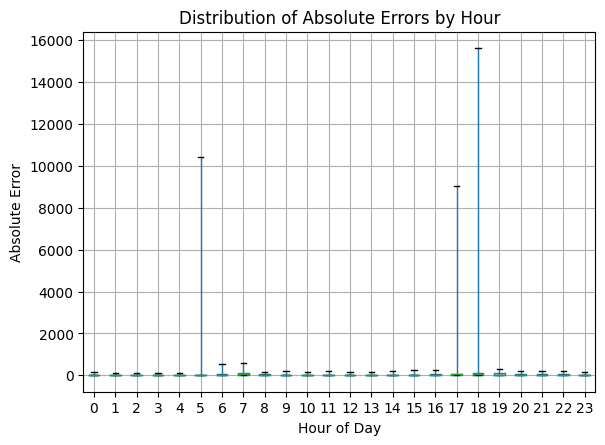

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 假設 results_df 是包含 'Actual' 和 'Predicted' 列的 DataFrame，索引為日期時間

# 計算每小時的 MAE
results_df['hour'] = results_df.index.hour
results_df['abs_error'] = np.abs(results_df['Actual'] - results_df['Predicted'])

hourly_mae = results_df.groupby('hour')['abs_error'].mean().sort_values(ascending=False)

# 打印每小時的 MAE，從最大到最小排序
print("Hourly MAE (sorted from highest to lowest):")
print(hourly_mae)

# 繪製長條圖
plt.figure(figsize=(12, 6))
hourly_mae.plot(kind='bar')
plt.title('Mean Absolute Error by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 計算累積 MAE
cumulative_mae = hourly_mae.cumsum()

# 繪製累積 MAE 的長條圖
plt.figure(figsize=(12, 6))
cumulative_mae.plot(kind='bar')
plt.title('Cumulative Mean Absolute Error by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Cumulative Mean Absolute Error')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 計算每個小時對總 MAE 的貢獻百分比
total_mae = hourly_mae.sum()
mae_percentage = (hourly_mae / total_mae * 100).sort_values(ascending=False)

print("\nPercentage contribution to total MAE by hour:")
print(mae_percentage)

# 繪製貢獻百分比的餅圖
plt.figure(figsize=(12, 8))
plt.pie(mae_percentage, labels=mae_percentage.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage Contribution to Total MAE by Hour')
plt.axis('equal')  # 確保餅圖是圓的
plt.show()

# 找出 MAE 最高的前 5 個小時
top_5_hours = hourly_mae.nlargest(5)
print("\nTop 5 hours with highest MAE:")
print(top_5_hours)

# 為這些小時創建箱型圖
plt.figure(figsize=(15, 6))
results_df.boxplot(column='abs_error', by='hour', whis=[0, 100])
plt.title('Distribution of Absolute Errors by Hour')
plt.suptitle('')  # 移除自動生成的標題
plt.xlabel('Hour of Day')
plt.ylabel('Absolute Error')
plt.show()

Hourly Success Rate (sorted from highest to lowest):
hour
1     0.468750
4     0.454427
2     0.432292
3     0.421875
0     0.404948
5     0.391927
23    0.380449
21    0.350260
22    0.283854
6     0.283854
20    0.282552
16    0.227865
19    0.227865
17    0.209635
18    0.188802
7     0.186198
15    0.167969
8     0.161458
14    0.117188
9     0.065104
13    0.062500
11    0.054688
10    0.053385
12    0.050781
Name: is_successful, dtype: float64


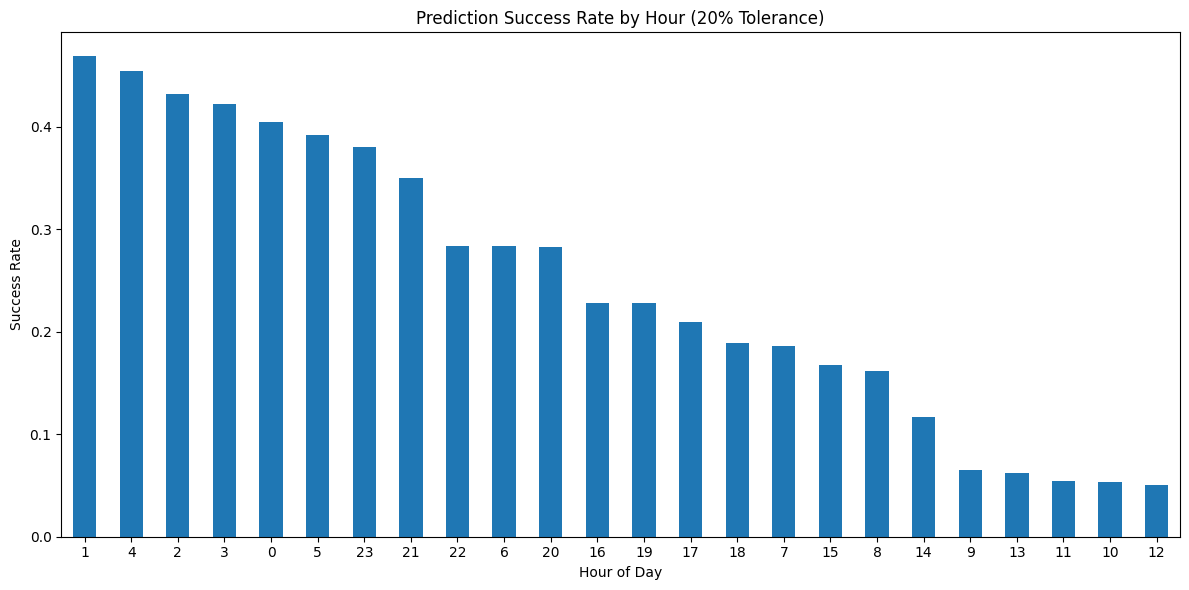

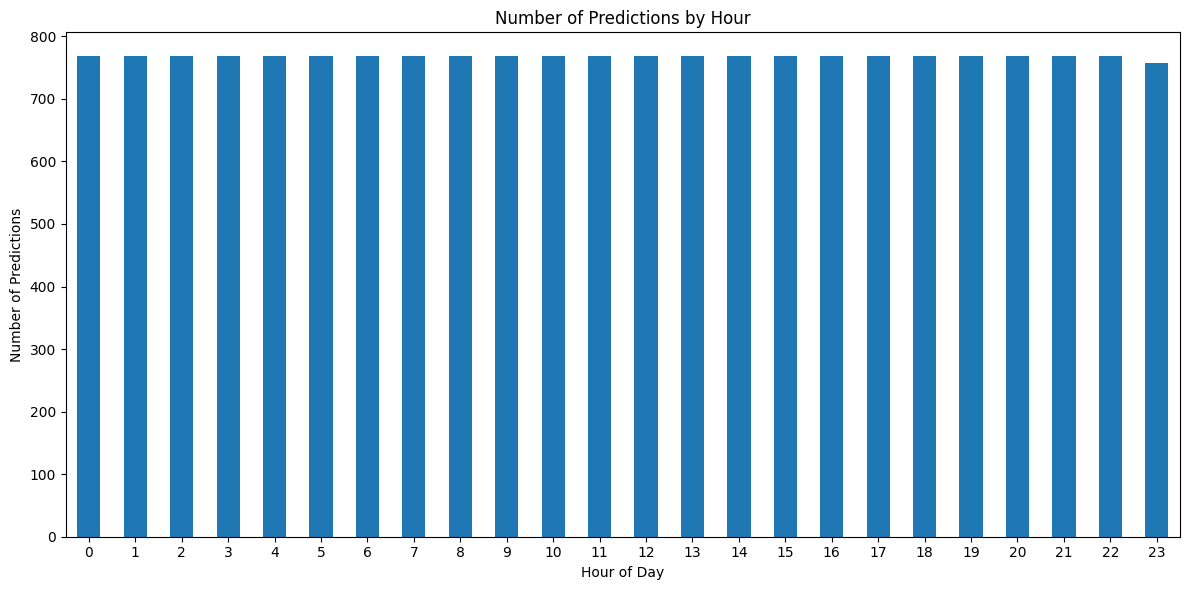


Top 5 hours with highest success rate:
hour
1    0.468750
4    0.454427
2    0.432292
3    0.421875
0    0.404948
Name: is_successful, dtype: float64

Bottom 5 hours with lowest success rate:
hour
12    0.050781
10    0.053385
11    0.054688
13    0.062500
9     0.065104
Name: is_successful, dtype: float64

Overall Success Rate: 24.69%


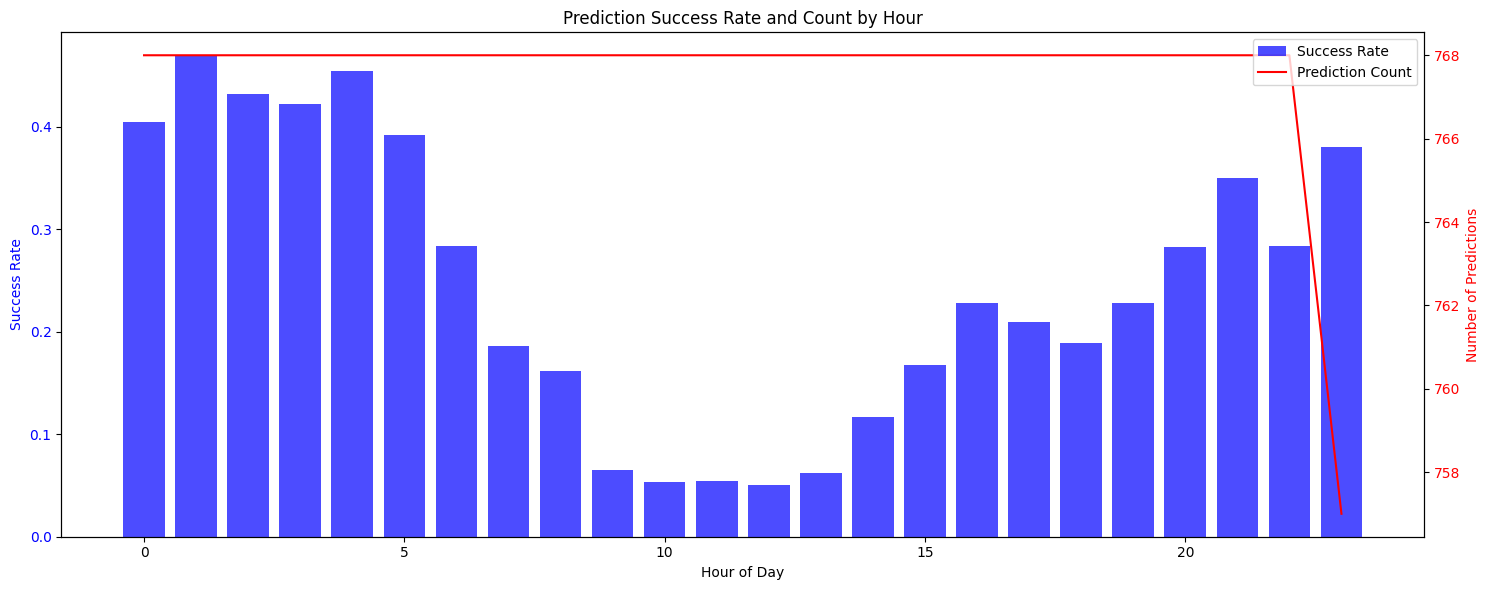

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 results_df 是包含 'Actual' 和 'Predicted' 列的 DataFrame，索引為日期時間

def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= actual * tolerance

# 添加成功/失敗的標記
results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)

# 按小時分組並計算成功率
results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)

# 計算每小時的預測次數
hourly_prediction_count = results_df.groupby('hour').size()

# 打印每小時的成功率，從高到低排序
print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)

# 繪製成功率的長條圖
plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (20% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 繪製每小時預測次數的長條圖
plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 找出成功率最高和最低的前 5 個小時
top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)

# 計算總體成功率
overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")

# 繪製成功率和預測次數的組合圖
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Success Rate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
ax2.set_ylabel('Number of Predictions', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Prediction Success Rate and Count by Hour')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()